In [ ]:
!pip install kaggle scikit-image

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
User cancelled operation
replace ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install scikit-image mlxtend

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW
from skimage.feature import local_binary_pattern

In [ ]:
# Assuming Kaggle input paths; adjust if running locally
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

df = pd.read_csv("full_df.csv")
df.head()

def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

/kaggle/input
Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:

left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(cataract),len(normal))

594 500


In [ ]:

dataset_dir = "preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:

            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            lbp = local_binary_pattern(image, P=8, R=1, method='uniform')

            lbp = (lbp / lbp.max() * 255).astype(np.uint8)

            lbp_resized = cv2.resize(lbp, (image_size, image_size))

            image = cv2.cvtColor(lbp_resized, cv2.COLOR_GRAY2BGR)
        except:
            continue
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

dataset = create_dataset(cataract,1)
len(dataset)

dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:29<00:00, 17.06it/s]


1088

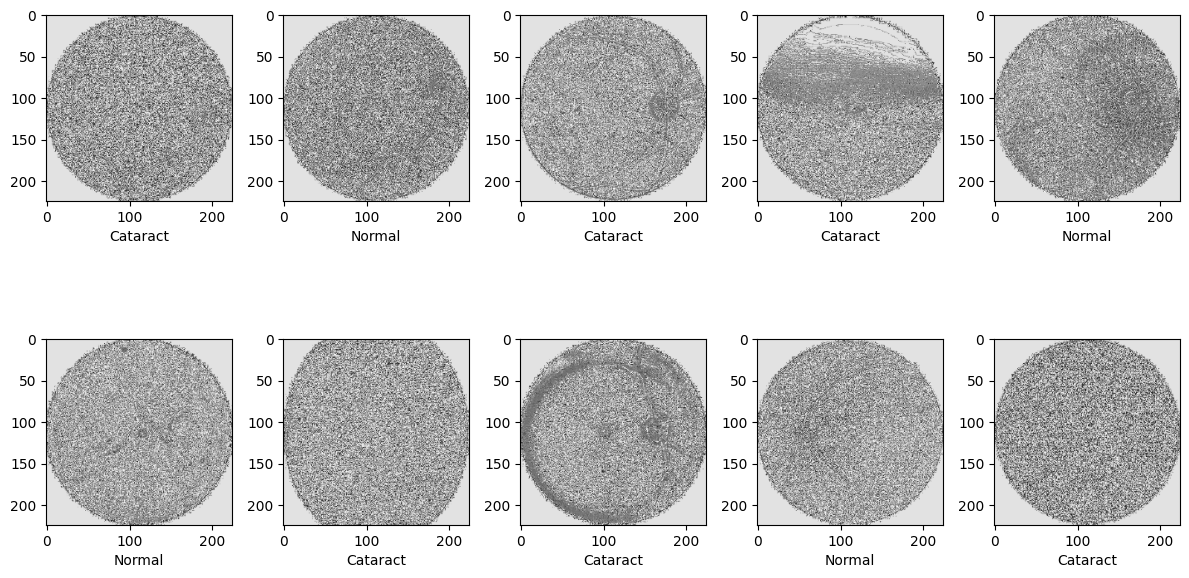

In [ ]:

plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:

# VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

model1 = Sequential()
model1.add(vgg)
model1.add(Flatten())
model1.add(Dense(1,activation="sigmoid"))
model1.summary()

model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("rnet50.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=False, save_freq='epoch')
# earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, mode='max')

history1 = model1.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5461 - loss: 8.3752
Epoch 1: val_accuracy improved from -inf to 0.75688, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 830ms/step - accuracy: 0.5477 - loss: 8.3119 - val_accuracy: 0.7569 - val_loss: 2.2361
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7732 - loss: 2.0022
Epoch 2: val_accuracy improved from 0.75688 to 0.85321, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.7747 - loss: 1.9844 - val_accuracy: 0.8532 - val_loss: 0.8131
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8854 - loss: 0.5416
Epoch 3: val_accuracy did not improve from 0.85321
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.8853 - loss: 0.5408 - val_accuracy: 0.8028 - val_loss: 1.0488
Epoch 4/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8547 - loss: 0.5880
Epoch 4: val_accuracy did not improve from 0.85321
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.8568 - loss: 0.5750 - val_accuracy: 0.8440 - val_loss: 0.6765
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9704 - loss: 0.0975
Epoch 5: val_accuracy improved from 0.85321 to 0.88991, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9703 - loss: 0.0976 - val_accuracy: 0.8899 - val_loss: 0.5465
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9860 - loss: 0.0355
Epoch 6: val_accuracy did not improve from 0.88991
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.9860 - loss: 0.0355 - val_accuracy: 0.8303 - val_loss: 0.6859
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9734 - loss: 0.0783
Epoch 7: val_accuracy improved from 0.88991 to 0.91284, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.9734 - loss: 0.0780 - val_accuracy: 0.9128 - val_loss: 0.4742
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9925 - loss: 0.0161
Epoch 8: val_accuracy did not improve from 0.91284
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.9926 - loss: 0.0161 - val_accuracy: 0.9128 - val_loss: 0.5787
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9991 - loss: 0.0075
Epoch 9: val_accuracy did not improve from 0.91284
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.9991 - loss: 0.0075 - val_accuracy: 0.9128 - val_loss: 0.5550
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 10: val_accuracy did not improve from 0.91284
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9128 - val_loss: 0.5327


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.9192 - loss: 0.5584
loss: 0.5327392220497131
Accuracy: 0.9128440618515015
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90        98
           1       0.92      0.93      0.92       120

    accuracy                           0.91       218
   macro avg       0.91      0.91      0.91       218
weighted avg       0.91      0.91      0.91       218



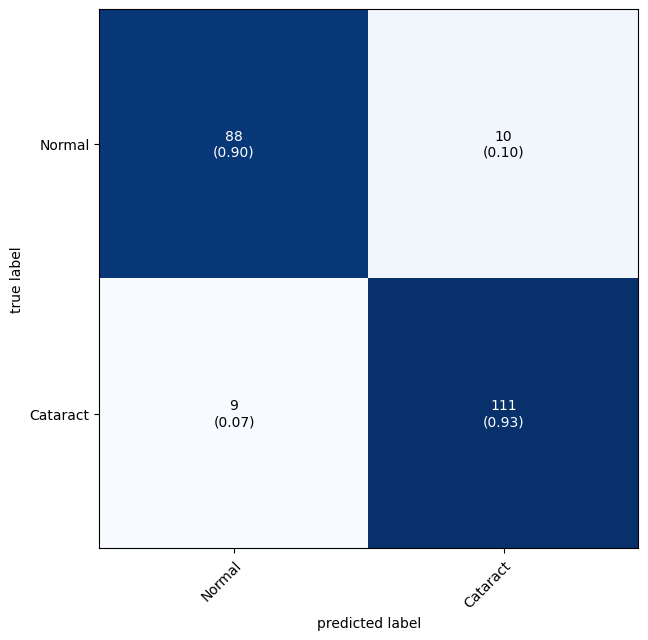

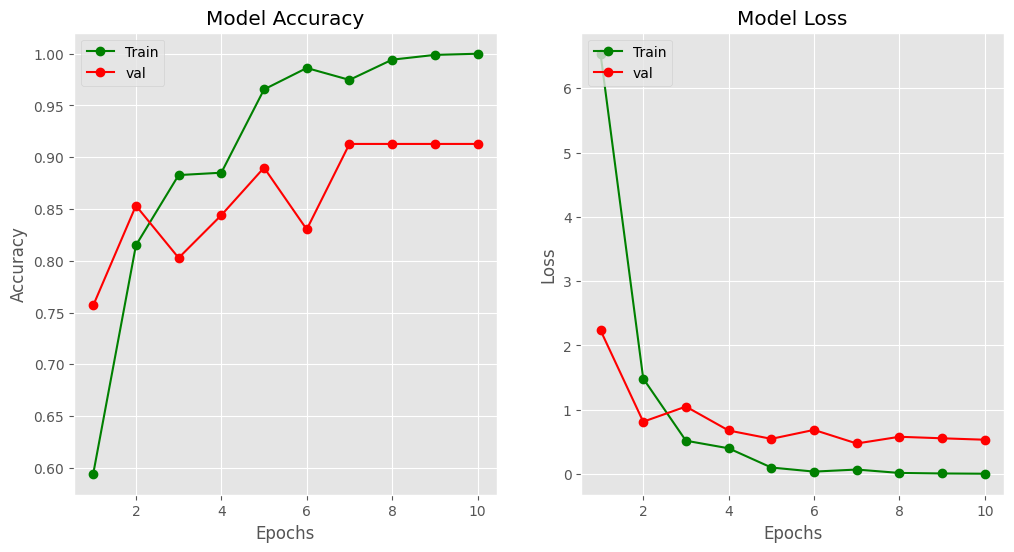

In [ ]:

loss,accuracy = model1.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

y_pred1 = (model1.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred1)

print(classification_report(y_test,y_pred1))

cm = confusion_matrix(y_test,y_pred1)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history1.history["accuracy"],"go-")
plt.plot(epochs,history1.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history1.history["loss"],"go-")
plt.plot(epochs,history1.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()


In [ ]:
# ResNet50
rnet = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

for layer in rnet.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(rnet)
model2.add(Flatten())
model2.add(Dense(1, activation="sigmoid"))
model2.summary()

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("rnet50.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, mode='max')

history2 = model2.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                      verbose=1, callbacks=[checkpoint, earlystop])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5549 - loss: 4.5975
Epoch 1: val_accuracy improved from -inf to 0.77064, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 702ms/step - accuracy: 0.5582 - loss: 4.5345 - val_accuracy: 0.7706 - val_loss: 1.3250
Epoch 2/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8547 - loss: 0.6602
Epoch 2: val_accuracy improved from 0.77064 to 0.88073, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.8567 - loss: 0.6468 - val_accuracy: 0.8807 - val_loss: 0.4865
Epoch 3/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9105 - loss: 0.2484
Epoch 3: val_accuracy did not improve from 0.88073
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9118 - loss: 0.2456 - val_accuracy: 0.8807 - val_loss: 0.4794
Epoch 4/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9612 - loss: 0.1052
Epoch 4: val_accuracy did not improve from 0.88073
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9610 - loss: 0.1051 - val_accuracy: 0.8211 - val_loss: 0.7278
Epoch 5/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9604 - loss: 0.1239
Epoch 5: val_accuracy improved from 0.88073 to 0.90367, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9613 - loss: 0.1206 - val_accuracy: 0.9037 - val_loss: 0.3607
Epoch 6/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9898 - loss: 0.0423
Epoch 6: val_accuracy improved from 0.90367 to 0.91743, saving model to rnet50.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9900 - loss: 0.0415 - val_accuracy: 0.9174 - val_loss: 0.2942
Epoch 7/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9963 - loss: 0.0225
Epoch 7: val_accuracy did not improve from 0.91743
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9964 - loss: 0.0226 - val_accuracy: 0.9128 - val_loss: 0.2935
Epoch 8/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9970 - loss: 0.0186
Epoch 8: val_accuracy did not improve from 0.91743
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9970 - loss: 0.0185 - val_accuracy: 0.9174 - val_loss: 0.2849
Epoch 9/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0116
Epoch 9: val_accuracy did not improve from 0.91743
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.9037 - val_loss: 0.4028
Epoch 10/10
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9899 - loss: 0.0384
Epoch 10: val_accuracy did not improve

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9306 - loss: 0.2858
loss: 0.31374284625053406
Accuracy: 0.9128440618515015
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 824ms/step
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        98
           1       0.91      0.93      0.92       120

    accuracy                           0.91       218
   macro avg       0.91      0.91      0.91       218
weighted avg       0.91      0.91      0.91       218



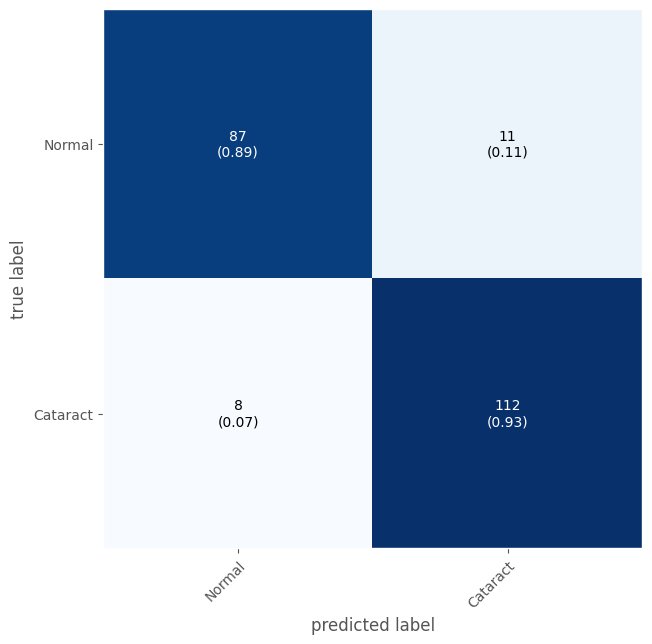

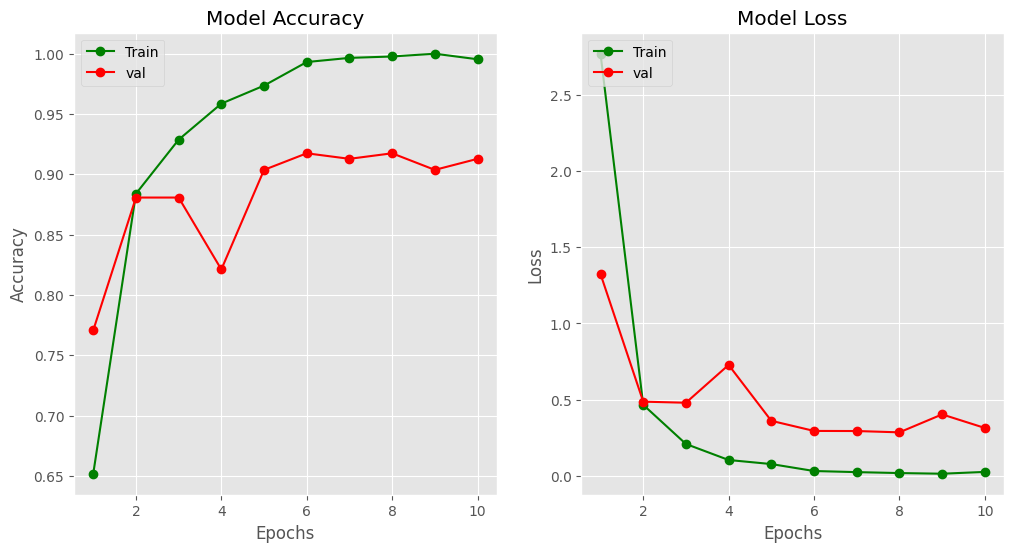

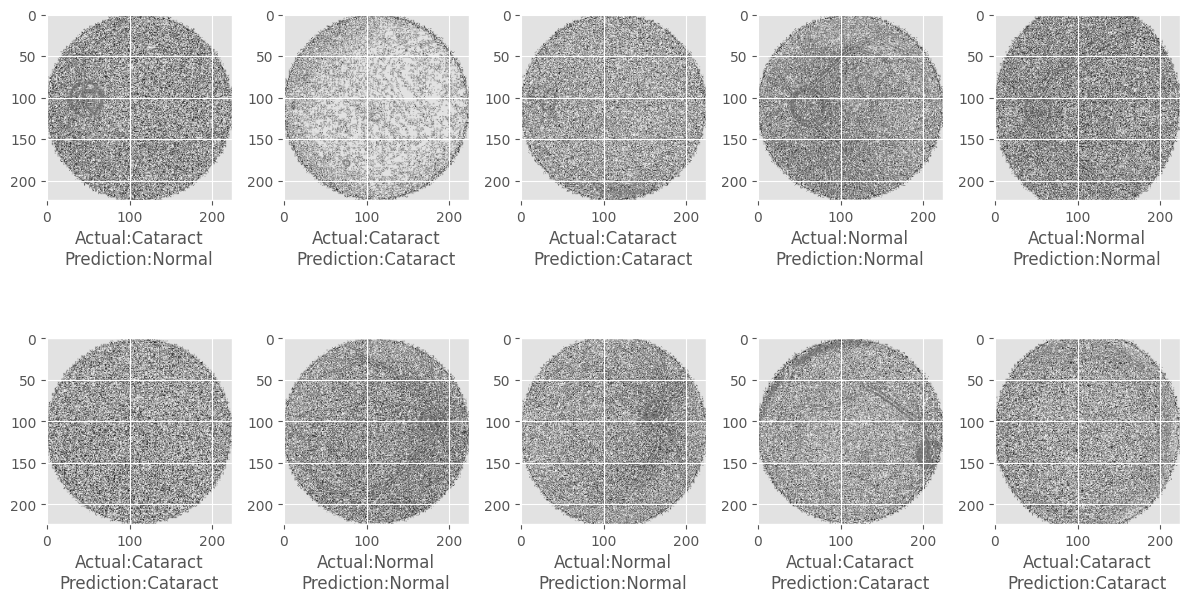

In [ ]:

loss,accuracy = model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

y_pred2 = (model2.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred2)

print(classification_report(y_test,y_pred2))

cm = confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history2.history["accuracy"],"go-")
plt.plot(epochs,history2.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history2.history["loss"],"go-")
plt.plot(epochs,history2.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred2[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

In [ ]:

# Vision Transformers
num_classes = 2
input_shape = (224, 224, 3)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
image_size = 128 # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


x_train shape: (870, 224, 224, 3) - y_train shape: (870,)
x_test shape: (218, 224, 224, 3) - y_test shape: (218,)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Image size: 128 X 128
Patch size: 6 X 6
Patches per image: 441
Elements per patch: 108


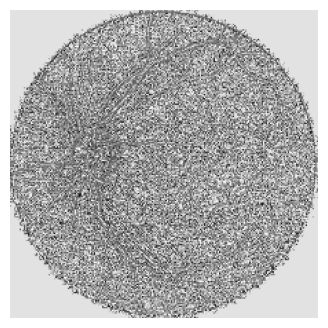

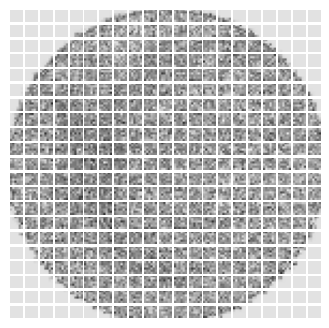

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model3 = keras.Model(inputs=inputs, outputs=logits)
    return model3


In [ ]:

model3 = create_vit_classifier()
model3.summary()

num_epochs = 30

optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model3.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

checkpoint_filepath = "/tmp/vit_multiclass.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

history3 = model3.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

# model3.load_weights(checkpoint_filepath)
model3.load_weights(checkpoint_filepath)
_, accuracy = model3.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

loss, accuracy = model3.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          7 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 441, 64)   │     35,200 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 441, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 441, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 441, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 441, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 441, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 441, 128)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 441, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 441, 64)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 441, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 441, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 441, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 441, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 441, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 441, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 441, 128)  │          0 │ dense_5[0][0]   

 Total params: 15,117,577 (57.67 MB)

 Trainable params: 15,117,570 (57.67 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 306ms/step - accuracy: 0.5989 - loss: 5.2524 - val_accuracy: 0.7701 - val_loss: 0.6913
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.7083 - loss: 1.6645 - val_accuracy: 0.7701 - val_loss: 0.4320
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.8126 - loss: 0.7140 - val_accuracy: 0.7816 - val_loss: 0.5021
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7837 - loss: 0.5399 - val_accuracy: 0.7471 - val_loss: 0.5153
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.8327 - loss: 0.4179 - val_accuracy: 0.8736 - val_loss: 0.2785
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8312 - loss: 0.4206 - val_accuracy: 0.8621 - val_loss: 0.2755
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.8472 - loss: 0.3640 - val_accuracy: 0.8851 - val_loss: 0.2616
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8745 - loss: 0.2984 - val_accuracy: 0

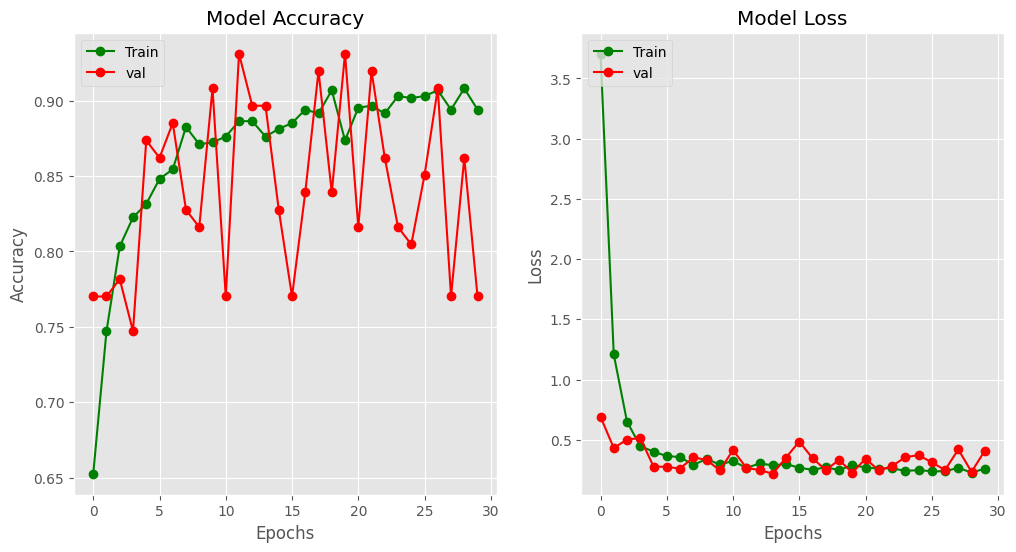

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

len(val_acc),len(val_loss),len(acc),len(loss)

EPOCHS = 30

plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history3.history['accuracy'],"go-")
plt.plot(range(EPOCHS), history3.history['val_accuracy'],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history3.history['loss'],"go-")
plt.plot(range(EPOCHS), history3.history['val_loss'],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()


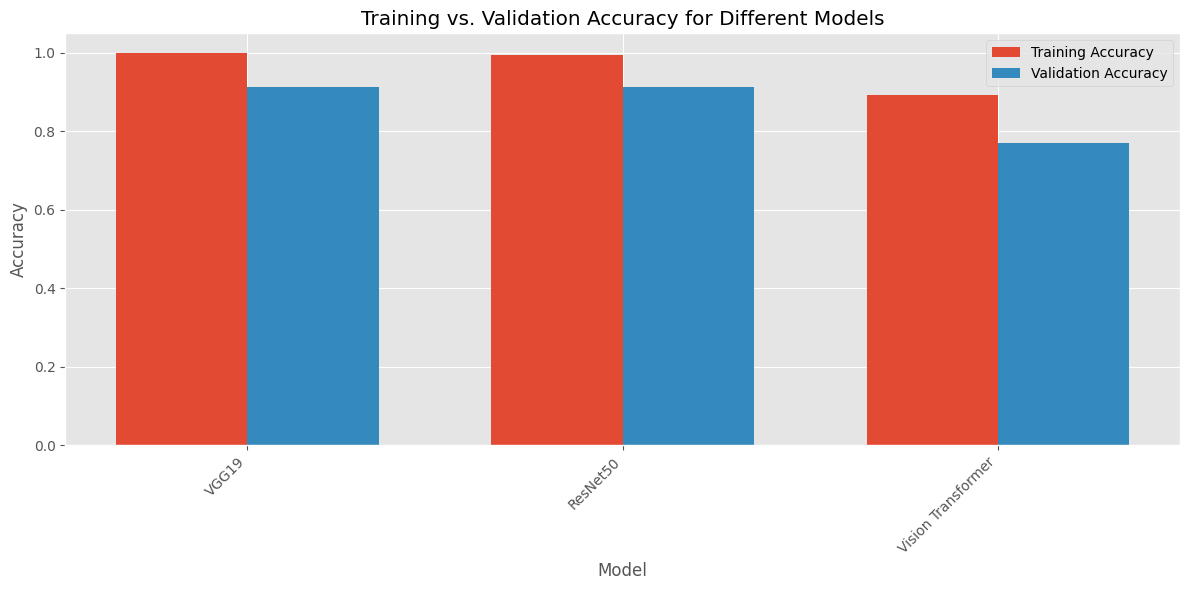

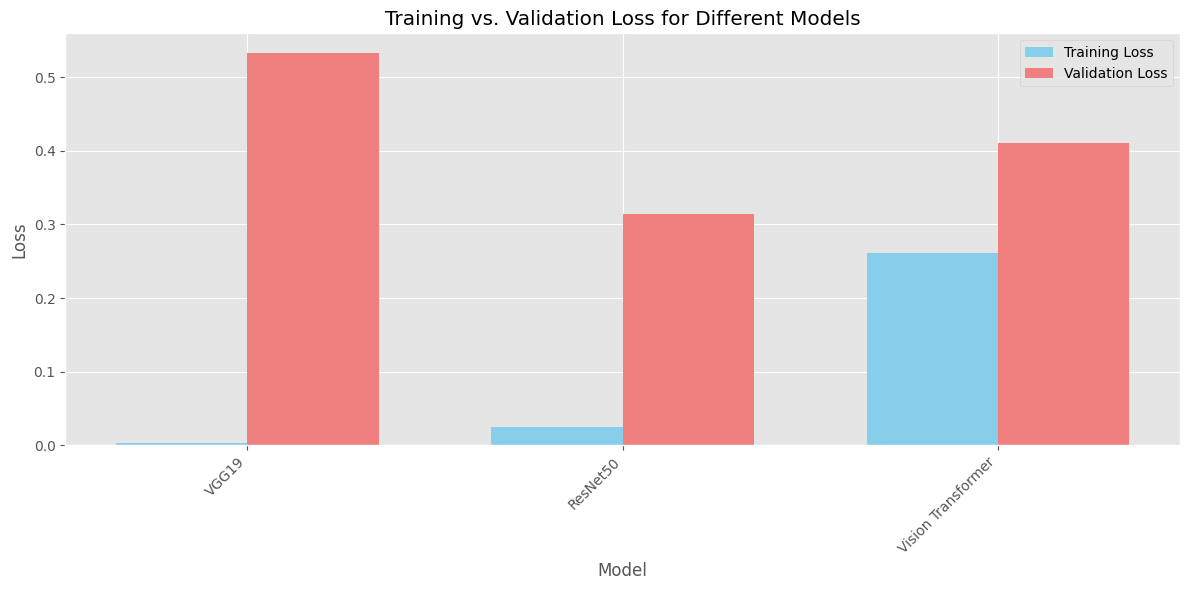

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to store the performance metrics of the models
comp = pd.DataFrame({
    'Model': ['VGG19', 'ResNet50', 'Vision Transformer'],
    'Training_Accuracy': [history1.history['accuracy'][-1], history2.history['accuracy'][-1], history3.history['accuracy'][-1]],
    'Validation_Accuracy': [history1.history['val_accuracy'][-1], history2.history['val_accuracy'][-1], history3.history['val_accuracy'][-1]],
    'Training_Loss': [history1.history['loss'][-1], history2.history['loss'][-1], history3.history['loss'][-1]],
    'Validation_Loss': [history1.history['val_loss'][-1], history2.history['val_loss'][-1], history3.history['val_loss'][-1]]
})

metrics = ['Training_Accuracy', 'Validation_Accuracy', 'Training_Loss', 'Validation_Loss']
models = comp['Model'].tolist()

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(models))

plt.bar([i - bar_width/2 for i in index], comp['Training_Accuracy'], bar_width, label='Training Accuracy')
plt.bar([i + bar_width/2 for i in index], comp['Validation_Accuracy'], bar_width, label='Validation Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy for Different Models')
plt.xticks(index, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in index], comp['Training_Loss'], bar_width, label='Training Loss', color='skyblue')
plt.bar([i + bar_width/2 for i in index], comp['Validation_Loss'], bar_width, label='Validation Loss', color='lightcoral')

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss for Different Models')
plt.xticks(index, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()